International Monetary Fund API with Python
=====

## Brazil, Chile, and Colombia CPI inflation example

*April 8, 2018*<br>
*@bd_econ*

-----

IMF API Documentation is [here](http://datahelp.imf.org/knowledgebase/articles/667681-json-restful-web-service)

In [1]:
# Python 3.6
import requests
import pandas as pd

#### Parameters/ Settings

In [2]:
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
param = [('dataset', 'IFS'),
         ('freq', 'M'),
         # Brazil, Chile, Colombia
         ('country', 'BR+CL+CO'),
         ('series', 'PCPI_IX'),
         ('start', '?startPeriod=2009')]
series = '.'.join([i[1] for i in param[1:4]])

key = f'CompactData/{param[0][1]}/{series}{param[-1][1]}'

#### Make request and convert to annual percent change

In [3]:
# Combine API url with key specific to data request
r = requests.get(f'{url}{key}').json()
# data portion of results
data = r['CompactData']['DataSet']['Series']

In [4]:
# Create pandas dataframe, column = country, row = obs
df = pd.DataFrame({s['@REF_AREA']: # Each country/area
                   {i['@TIME_PERIOD']: float(i['@OBS_VALUE']) 
                    for i in s['Obs']} for s in data})

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Calculate inflation rate and drop empty rows
df = (df.pct_change(12) * 100).round(1).dropna()

#### Plot results

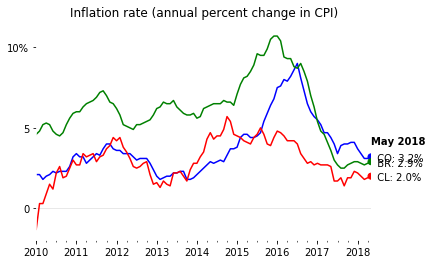

In [5]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc('axes',edgecolor='w')

ax = df.plot(title='Inflation rate (annual percent change in CPI)', 
             color=['blue', 'red', 'green'], legend=False)
ax = plt.axhline(0, color='lightgray', lw=0.5, zorder=-1)
ax = plt.scatter([df.index[-1]] * 3, df.iloc[-1].values, 
                 color=['blue', 'red', 'green'])
for i, txt in enumerate(df.iloc[-1].values):
    ax = plt.annotate(f'  {df.iloc[-1].index[i]}: {txt:.2}%', 
                      (df.index[-1], txt-0.25))
ax = plt.annotate(f'{df.index[-1]:%b %Y}', (df.index[-1], df.iloc[-1].max() + 0.8), 
                  fontweight='bold')
ax = plt.xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2018-05-01'))
ax = plt.ylim(-1.95, 11.55)
ax = plt.yticks([10, 5, 0], ['10%', '5', '0'])

------

## Metadata and param lookup examples

#### Find available series by search term "trade"

In [6]:
key = 'Dataflow'  # Method with series information
t = 'Trade'  # Term to find in series names
sl = requests.get(f'{url}{key}').json()['Structure']['Dataflows']['Dataflow']
# Print list of series containing text t
for s in (s for s in sl if t in s['Name']['#text']): 
    code = s['KeyFamilyRef']['KeyFamilyID']
    print(f"{s['Name']['#text']}: {code}")

Direction of Trade Statistics (DOTS): DOT
International Trade in Services: ITS
Direction of Trade Statistics (DOTS), 2017 Q1: DOT_2017Q1
Prices, Production, Labor and Trade (PPLT): PPLT
Direction of Trade Statistics (DOTS), 2017 Q2: DOT_2017Q2
Direction of Trade Statistics (DOTS), 2017 Q3: DOT_2017Q3


#### Print the dimensions for a given series, "DOT"

In [7]:
key = 'DataStructure/DOT'  # Method / series
dl = requests.get(f'{url}{key}').json()\
    ['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension']
for n, d in enumerate(dl):
    print(f"Dimension {n+1}: {d['@codelist']}")

Dimension 1: CL_FREQ
Dimension 2: CL_AREA_DOT
Dimension 3: CL_INDICATOR_DOT
Dimension 4: CL_COUNTERPART_AREA_DOT


#### See what values are acceptable for dimension "CL_INDICATOR_DOT"

In [8]:
# Example: codes for dimension 3
key = f"CodeList/{dl[2]['@codelist']}"
cl = requests.get(f'{url}{key}').json()['Structure']['CodeLists']['CodeList']['Code']
for c in cl:
    print(f"{c['Description']['#text']}: {c['@value']}")

Goods, Value of Exports, Free on board (FOB), US Dollars: TXG_FOB_USD
Goods, Value of Imports, Cost, Insurance, Freight (CIF), US Dollars: TMG_CIF_USD
Goods, Value of Imports, Free on board (FOB), US Dollars: TMG_FOB_USD
Goods, Value of Trade Balance, US Dollars: TBG_USD


#### Bad example for how to get metadata

Probably better to just print the text, m, and read it.

In [9]:
key = 'GenericMetadata/IFS/M.GB.PMP_IX'
m = requests.get(f'{url}{key}').json()['GenericMetadata']['MetadataSet']['AttributeValueSet']
country = m[1]['ReportedAttribute'][1]['ReportedAttribute'][3]['Value']['#text']
indicator = m[2]['ReportedAttribute'][1]['ReportedAttribute'][3]['Value']['#text']
print(f'Country: {country}; Indicator: {indicator}')

Country: United Kingdom; Indicator: Prices, Import Price Index, All Commodities, Index


In [11]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
#import seaborn
matplotlib.rc('axes',edgecolor='w')

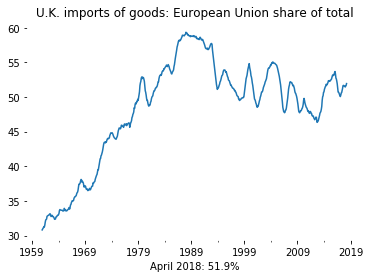

In [12]:
import pandas as pd           # pandas version 0.18.1

# key includes two partners, B0 and W00 for EU and world
key = 'CompactData/DOT/M.GB.TMG_CIF_USD.B0+W00'

# Retrieve data from IMF API
data = requests.get(f'{url}{key}').json()

# Convert results to pandas dataframe
df = pd.DataFrame({s['@COUNTERPART_AREA'] : {pd.to_datetime(i['@TIME_PERIOD']) : 
     round(float(i['@OBS_VALUE']), 1) for i in s['Obs']} 
     for s in data['CompactData']['DataSet']['Series']})

# 12 month moving average of EU share of total
eu_share = (df['B0'].div(df['W00']) * 100).rolling(12).mean()

# Create a line plot and print most recent value as x label
title = "U.K. imports of goods: European Union share of total"
recent = f"{eu_share.index[-1].strftime('%B %Y')}: {eu_share[-1].round(1)}%"
ax = eu_share.plot(title=title)
ax = ax.set_xlabel(recent)

In [14]:
# Example: loading IMF data into pandas

# Import libraries
import requests
import pandas as pd

# URL for the IMF JSON Restful Web Service, 
# IFS database, and Australian export prices series
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q.AU.PXP_IX.?startPeriod=1957&endPeriod=2018'

# Get data from the above URL using the requests package
data = requests.get(url).json()

# Load data into a pandas dataframe
auxp = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])

# Show the last five observiations
auxp.tail()

,@OBS_VALUE,@TIME_PERIOD
228,107.352530053117,2017-Q1
229,101.202124685491,2017-Q2
230,98.1828347777467,2017-Q3
231,100.978473581213,2017-Q4
232,105.898797875315,2018-Q1


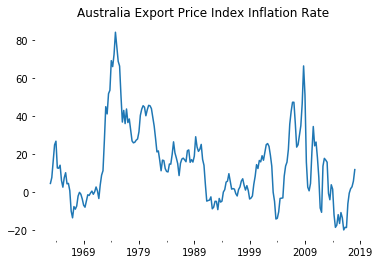

In [69]:
import requests
import pandas as pd
%matplotlib inline

url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = 'CompactData/IFS/Q.AU.PXP_IX' # adjust codes here
r = requests.get(f'{url}{key}').json()
obs = r['CompactData']['DataSet']['Series']['Obs']
(pd.Series({pd.to_datetime(i['@TIME_PERIOD']): 
            float(i['@OBS_VALUE']) 
            for i in obs}).pct_change(12).multiply(100)
 .plot(title='Australia Export Price Index Inflation Rate'))

In [21]:
r = requests.get(f'{url}{key}').json()

In [43]:
obs = r['CompactData']['DataSet']['Series']['Obs']

In [55]:
{i['@TIME_PERIOD']: float(i['@OBS_VALUE']) 
                    for i in obs}

{'1960-Q1': 10.311931766636,
 '1960-Q2': 10.2084675683085,
 '1960-Q3': 9.58768237834382,
 '1960-Q4': 9.55319431223466,
 '1961-Q1': 9.76012270888956,
 '1961-Q2': 10.2429556344177,
 '1961-Q3': 10.0705153038719,
 '1961-Q4': 9.69114657667127,
 '1962-Q1': 9.93256303943532,
 '1962-Q2': 10.1394914360902,
 '1962-Q3': 9.82909884110787,
 '1962-Q4': 10.0360272377628,
 '1963-Q1': 10.7947646921641,
 '1963-Q2': 11.001693088819,
 '1963-Q3': 11.1741334193647,
 '1963-Q4': 11.932870873766,
 '1964-Q1': 12.381215733185,
 '1964-Q2': 11.5535021465654,
 '1964-Q3': 11.3465737499105,
 '1964-Q4': 11.0706692210373,
 '1965-Q1': 10.5533482294,
 '1965-Q2': 10.4153959649634,
 '1965-Q3': 10.5878362955092,
 '1965-Q4': 11.0706692210373,
 '1966-Q1': 11.2775976176922,
 '1966-Q2': 11.5190140804562,
 '1966-Q3': 11.2775976176922,
 '1966-Q4': 10.7602766260549,
 '1967-Q1': 10.7257885599458,
 '1967-Q2': 10.6913004938366,
 '1967-Q3': 10.3464198327451,
 '1967-Q4': 10.2774437005268,
 '1968-Q1': 10.3464198327451,
 '1968-Q2': 10.41

In [58]:
# Create pandas dataframe, column = country, row = obs
df = pd.Series({i['@TIME_PERIOD']: float(i['@OBS_VALUE']) 
                    for i in obs})

TypeError: __init__() got an unexpected keyword argument 'parse_date'

In [57]:
df

1960-Q1     10.311932
1960-Q2     10.208468
1960-Q3      9.587682
1960-Q4      9.553194
1961-Q1      9.760123
1961-Q2     10.242956
1961-Q3     10.070515
1961-Q4      9.691147
1962-Q1      9.932563
1962-Q2     10.139491
1962-Q3      9.829099
1962-Q4     10.036027
1963-Q1     10.794765
1963-Q2     11.001693
1963-Q3     11.174133
1963-Q4     11.932871
1964-Q1     12.381216
1964-Q2     11.553502
1964-Q3     11.346574
1964-Q4     11.070669
1965-Q1     10.553348
1965-Q2     10.415396
1965-Q3     10.587836
1965-Q4     11.070669
1966-Q1     11.277598
1966-Q2     11.519014
1966-Q3     11.277598
1966-Q4     10.760277
1967-Q1     10.725789
1967-Q2     10.691300
              ...    
2010-Q4    100.866648
2011-Q1    106.010623
2011-Q2    112.496505
2011-Q3    116.857702
2011-Q4    115.180319
2012-Q1    107.128879
2012-Q2    108.135309
2012-Q3    101.202125
2012-Q4     98.741963
2013-Q1    101.537601
2013-Q2    101.202125
2013-Q3    105.451496
2013-Q4    104.892368
2014-Q1    107.799832
2014-Q2   

In [47]:
pd.Series(obs, index=['@TIME_PERIOD'])

0      {'@TIME_PERIOD': '1960-Q1', '@OBS_VALUE': '10....
1      {'@TIME_PERIOD': '1960-Q2', '@OBS_VALUE': '10....
2      {'@TIME_PERIOD': '1960-Q3', '@OBS_VALUE': '9.5...
3      {'@TIME_PERIOD': '1960-Q4', '@OBS_VALUE': '9.5...
4      {'@TIME_PERIOD': '1961-Q1', '@OBS_VALUE': '9.7...
5      {'@TIME_PERIOD': '1961-Q2', '@OBS_VALUE': '10....
6      {'@TIME_PERIOD': '1961-Q3', '@OBS_VALUE': '10....
7      {'@TIME_PERIOD': '1961-Q4', '@OBS_VALUE': '9.6...
8      {'@TIME_PERIOD': '1962-Q1', '@OBS_VALUE': '9.9...
9      {'@TIME_PERIOD': '1962-Q2', '@OBS_VALUE': '10....
10     {'@TIME_PERIOD': '1962-Q3', '@OBS_VALUE': '9.8...
11     {'@TIME_PERIOD': '1962-Q4', '@OBS_VALUE': '10....
12     {'@TIME_PERIOD': '1963-Q1', '@OBS_VALUE': '10....
13     {'@TIME_PERIOD': '1963-Q2', '@OBS_VALUE': '11....
14     {'@TIME_PERIOD': '1963-Q3', '@OBS_VALUE': '11....
15     {'@TIME_PERIOD': '1963-Q4', '@OBS_VALUE': '11....
16     {'@TIME_PERIOD': '1964-Q1', '@OBS_VALUE': '12....
17     {'@TIME_PERIOD': '1964-Q

In [20]:
data['CompactData']['DataSet']['Series']

{'@FREQ': 'Q',
 '@REF_AREA': 'AU',
 '@INDICATOR': 'PXP_IX',
 '@UNIT_MULT': '0',
 '@BASE_YEAR': '2010=100',
 '@TIME_FORMAT': 'P3M',
 'Obs': [{'@TIME_PERIOD': '1960-Q1', '@OBS_VALUE': '10.311931766636'},
  {'@TIME_PERIOD': '1960-Q2', '@OBS_VALUE': '10.2084675683085'},
  {'@TIME_PERIOD': '1960-Q3', '@OBS_VALUE': '9.58768237834382'},
  {'@TIME_PERIOD': '1960-Q4', '@OBS_VALUE': '9.55319431223466'},
  {'@TIME_PERIOD': '1961-Q1', '@OBS_VALUE': '9.76012270888956'},
  {'@TIME_PERIOD': '1961-Q2', '@OBS_VALUE': '10.2429556344177'},
  {'@TIME_PERIOD': '1961-Q3', '@OBS_VALUE': '10.0705153038719'},
  {'@TIME_PERIOD': '1961-Q4', '@OBS_VALUE': '9.69114657667127'},
  {'@TIME_PERIOD': '1962-Q1', '@OBS_VALUE': '9.93256303943532'},
  {'@TIME_PERIOD': '1962-Q2', '@OBS_VALUE': '10.1394914360902'},
  {'@TIME_PERIOD': '1962-Q3', '@OBS_VALUE': '9.82909884110787'},
  {'@TIME_PERIOD': '1962-Q4', '@OBS_VALUE': '10.0360272377628'},
  {'@TIME_PERIOD': '1963-Q1', '@OBS_VALUE': '10.7947646921641'},
  {'@TIME_PERIOD':

In [19]:
pd.DataFrame(['Obs'])

,@OBS_VALUE,@TIME_PERIOD
0,10.311931766636,1960-Q1
1,10.2084675683085,1960-Q2
2,9.58768237834382,1960-Q3
3,9.55319431223466,1960-Q4
4,9.76012270888956,1961-Q1
5,10.2429556344177,1961-Q2
6,10.0705153038719,1961-Q3
7,9.69114657667127,1961-Q4
8,9.93256303943532,1962-Q1
9,10.1394914360902,1962-Q2


In [ ]:
import pandas as pd          # pandas version 0.22

# Navigate to observations in JSON data
obs = data['CompactData']['DataSet']['Series']['Obs']

# Create pandas dataframe from the observations
df = pd.DataFrame(obs)[['@OBS_VALUE','@TIME_PERIOD']]
df.columns = ['value', 'date']
df.loc[:,'value'] = df['value'].astype(float).round(1)
df = df.set_index(pd.to_datetime(df['date']))['value']

In [17]:
data

{'CompactData': {'@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  '@xmlns:xsd': 'http://www.w3.org/2001/XMLSchema',
  '@xsi:schemaLocation': 'http://www.SDMX.org/resources/SDMXML/schemas/v2_0/message https://registry.sdmx.org/schemas/v2_0/SDMXMessage.xsd http://dataservices.imf.org/compact/IFS http://dataservices.imf.org/compact/IFS.xsd',
  '@xmlns': 'http://www.SDMX.org/resources/SDMXML/schemas/v2_0/message',
  'Header': {'ID': 'fafda65d-01b9-467d-97ff-cbee99f2d184',
   'Test': 'false',
   'Prepared': '2018-08-20T17:51:23',
   'Sender': {'@id': '1C0',
    'Name': {'@xml:lang': 'en', '#text': 'IMF'},
    'Contact': {'URI': 'http://www.imf.org',
     'Telephone': '+ 1 (202) 623-6220'}},
   'Receiver': {'@id': 'ZZZ'},
   'DataSetID': 'IFS'},
  'DataSet': {'@xmlns': 'http://dataservices.imf.org/compact/IFS',
   'Series': {'@FREQ': 'Q',
    '@REF_AREA': 'AU',
    '@INDICATOR': 'PXP_IX',
    '@UNIT_MULT': '0',
    '@BASE_YEAR': '2010=100',
    '@TIME_FORMAT': 'P3M',
    'Obs': [

In [15]:
# Rename columns
auxp.columns = ['auxp','date']

# Set the price index series as a float (rather than string)
auxp.auxp = auxp.auxp.astype(float)

# Read the dates as quarters and set as the dataframe index
rng = pd.date_range(pd.to_datetime(auxp.date[0]), periods=len(auxp.index), freq='QS')
auxp = auxp.set_index(pd.DatetimeIndex(rng))
del auxp['date']

# Show last five rows
auxp.tail()

ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements